---
title: Comparing the predicted reference epigenome to Enformer runs centered at the TSS and ground truth
author: Sabrina Mi
date: 8/28/2023
descriptions: A correlation test on 10 hg38 genes showed that while relative position of the TSS in the input window noticeably affects predictions near the TSS, the four-bin average of CAGE:Brain values around the TSS are very similar.
---

We are trying to debug low correlation values between predicted reference CAGE values and reference observed gene expression by inspecting a few genes.

## Select Genes

In [1]:
#| output: false
import tensorflow as tf
# Make sure the GPU is enabled 
assert tf.config.list_physical_devices('GPU'), 'Start the colab kernel with GPU: Runtime -> Change runtime type -> GPU'
import tensorflow_hub as hub
import joblib
import gzip
import kipoiseq
from kipoiseq import Interval
import pyfaidx
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns


%matplotlib inline
%config InlineBackend.figure_format = 'retina'

transform_path = 'gs://dm-enformer/models/enformer.finetuned.SAD.robustscaler-PCA500-robustscaler.transform.pkl'
model_path = 'https://tfhub.dev/deepmind/enformer/1'
fasta_file = '/lus/grand/projects/TFXcan/imlab/data/hg_sequences/hg38/Homo_sapiens_assembly38.fasta'

2023-08-30 21:36:13.570806: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-30 21:36:14.967383: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /soft/compilers/cudatoolkit/cuda-11.8.0/extras/CUPTI/lib64:/soft/compilers/cudatoolkit/cuda-11.8.0/lib64:/soft/libraries/trt/TensorRT-8.5.2.2.Linux.x86_64-gnu.cuda-11.8.cudnn8.6/lib:/soft/libraries/nccl/nccl_2.16.2-1+cuda11.8_x86_64/lib:/soft/libraries/cudnn/cudnn-11-linux-x64-v8.6.0.163/lib:/opt/cray/pe/gcc/11.2.0/snos/lib64:/opt/cray/pe/papi/6.0.0.14/lib64:/opt/cray/libfabric/1.11.0.4.125/lib64:/

In [2]:
annot_df = pd.read_csv("/home/s1mi/enformer_rat_data/annotation/hg38.protein_coding_TSS.txt", sep="\t")
genes = annot_df.sample(n=10)
print(genes)

       ensembl_gene_id external_gene_name chromosome_name  \
2199   ENSG00000121898              CPXM2              10   
1804   ENSG00000162613              FUBP1               1   
15362  ENSG00000164327             RICTOR               5   
5786   ENSG00000087303               NID2              14   
4613   ENSG00000139233               LLPH              12   
6638   ENSG00000050820              BCAR1              16   
2681   ENSG00000171160              MORN4              10   
9526   ENSG00000181781             ODF3L2              19   
4709   ENSG00000123064              DDX54              12   
10435  ENSG00000135632              SMYD5               2   

       transcription_start_site  
2199                  123891807  
1804                   77979072  
15362                  39074399  
5786                   52069059  
4613                   66130750  
6638                   75251624  
2681                   97633500  
9526                     474983  
4709                  

## Run Enformer at the TSS

In [3]:
#| code-fold: true
SEQUENCE_LENGTH = 393216

class Enformer:

  def __init__(self, tfhub_url):
    self._model = hub.load(tfhub_url).model

  def predict_on_batch(self, inputs):
    predictions = self._model.predict_on_batch(inputs)
    return {k: v.numpy() for k, v in predictions.items()}

  @tf.function
  def contribution_input_grad(self, input_sequence,
                              target_mask, output_head='human'):
    input_sequence = input_sequence[tf.newaxis]

    target_mask_mass = tf.reduce_sum(target_mask)
    with tf.GradientTape() as tape:
      tape.watch(input_sequence)
      prediction = tf.reduce_sum(
          target_mask[tf.newaxis] *
          self._model.predict_on_batch(input_sequence)[output_head]) / target_mask_mass

    input_grad = tape.gradient(prediction, input_sequence) * input_sequence
    input_grad = tf.squeeze(input_grad, axis=0)
    return tf.reduce_sum(input_grad, axis=-1)
  
def plot_tracks(tracks, interval, height=1.5):
  fig, axes = plt.subplots(len(tracks), 1, figsize=(20, height * len(tracks)), sharex=True)
  for ax, (title, y) in zip(axes, tracks.items()):
    ax.fill_between(np.linspace(interval.start, interval.end, num=len(y)), y)
    ax.set_title(title)
    sns.despine(top=True, right=True, bottom=True)
  ax.set_xlabel(str(interval))
  plt.tight_layout()
  
class FastaStringExtractor:
    
    def __init__(self, fasta_file):
        self.fasta = pyfaidx.Fasta(fasta_file)
        self._chromosome_sizes = {k: len(v) for k, v in self.fasta.items()}

    def extract(self, interval: Interval, **kwargs) -> str:
        # Truncate interval if it extends beyond the chromosome lengths.
        chromosome_length = self._chromosome_sizes[interval.chrom]
        trimmed_interval = Interval(interval.chrom,
                                    max(interval.start, 0),
                                    min(interval.end, chromosome_length),
                                    )
        # pyfaidx wants a 1-based interval
        sequence = str(self.fasta.get_seq(trimmed_interval.chrom,
                                          trimmed_interval.start + 1,
                                          trimmed_interval.stop).seq).upper()
        # Fill truncated values with N's.
        pad_upstream = 'N' * max(-interval.start, 0)
        pad_downstream = 'N' * max(interval.end - chromosome_length, 0)
        return pad_upstream + sequence + pad_downstream

    def close(self):
        return self.fasta.close()
    
def one_hot_encode(sequence):
  return kipoiseq.transforms.functional.one_hot_dna(sequence).astype(np.float32)


In [4]:
model = Enformer(model_path)
fasta_extractor = FastaStringExtractor(fasta_file)

In [5]:
## Create Interval object for each TSS
intervals = [kipoiseq.Interval('chr'+ row['chromosome_name'], row['transcription_start_site'], row['transcription_start_site'])
            for _, row in genes.iterrows()]

In [11]:
tss_predictions = {}
for index, gene in enumerate(genes['ensembl_gene_id']):
    tss = intervals[index]
    sequence_one_hot = one_hot_encode(fasta_extractor.extract(tss.resize(SEQUENCE_LENGTH)))
    tss_predictions[gene] = model.predict_on_batch(sequence_one_hot[np.newaxis])['human'][0]

## Query Predicted Reference Epigenome at the TSS

In [7]:
#| code-fold: true
import h5py

enfref_dir = "/grand/TFXcan/imlab/users/lvairus/reftile_project/enformer-reference-epigenome"

def query_epigenome(chr_num, center_bp, num_bins=3, tracks=-1):
    """
    Parameters:
        path_to_enfref (str): path to the directory containing the concatenated reference enformer files
        chr_num (int/string): chromosome number
        center_bp (int): center base pair position (1-indexed)
        num_bins (int): number of bins to extract centered around center_bp (default: 896) 
            note: if the number of bins is even, the center bin will be in the second half of the array
        tracks (int list): list of tracks to extract (default: all 5313 tracks)

    Returns:
        epigen (np.array): enformer predictions centered at center_bp of shape (num_bins, len(tracks))
    """

    # from position choose center bin
    center_ind = center_bp - 1
    center_bin = center_ind // 128
    
    half_bins = num_bins // 2
    start_bin = center_bin - half_bins
    end_bin = center_bin + half_bins
    if num_bins % 2 != 0: # if num_bins is odd
        end_bin += 1

    with h5py.File(f"{enfref_dir}/chr{chr_num}_cat.h5", "r") as f:
        # get tracks if list provided
        if tracks == -1:
            epigen = f[f'chr{chr_num}'][start_bin:end_bin, :] 
        else:
            epigen = f[f'chr{chr_num}'][start_bin:end_bin, tracks] 

    return epigen

In [15]:
predicted_reference_epigenome = {}
for index, gene in enumerate(genes['ensembl_gene_id']):
    chr = genes.iloc[index]['chromosome_name']
    pos = genes.iloc[index]['transcription_start_site']
    predicted_reference_epigenome[gene] = query_epigenome(chr, pos, num_bins=896)

We'll save these matrices so we can come back to the same genes.

In [19]:
#| code-fold: true
# with h5py.File('/home/s1mi/enformer_rat_data/output/hg38_tss_predictions.h5', 'w') as hf:
#     for key, value in tss_predictions.items():
#         hf[key] = value
# with h5py.File('/home/s1mi/enformer_rat_data/output/hg38_reference_epigenome_tss.h5', 'w') as hf:
#     for key, value in predicted_reference_epigenome.items():
#         hf[key] = value

In [10]:
#| code-fold: false
# import h5py
# annot_df = pd.read_csv("/home/s1mi/enformer_rat_data/annotation/hg38.protein_coding_TSS.txt", sep="\t", index_col='ensembl_gene_id')
# predicted_reference_epigenome = {}
# with h5py.File('/home/s1mi/enformer_rat_data/output/hg38_reference_epigenome_tss.h5', 'r') as hf:
#     for key in hf.keys():
#         predicted_reference_epigenome[key] = hf[key][()]
# tss_predictions = {}
# with h5py.File('/home/s1mi/enformer_rat_data/output/hg38_tss_predictions.h5', 'r') as hf:
#     for key in hf.keys():
#         tss_predictions[key] = hf[key][()]


## Compare Matrices

I used Laura's matrix comparison functions, which can be expanded below:

In [12]:
#| code-fold: true
def get_diffmat(mat1, mat2):
    
    diffmat = mat1 - mat2
    colwise_maxes1 = np.max(mat1, axis=0)
    colwise_maxes2 = np.max(mat2, axis=0)

    colwise_maxes_maxes = np.maximum(colwise_maxes1, colwise_maxes2)

    relmax3_diffmat = diffmat / colwise_maxes_maxes
    relmax3_diffmat = np.abs(relmax3_diffmat)
    return relmax3_diffmat

def get_summary(arr):
    summary = {
        "mean": np.mean(arr),
        "median": np.median(arr),
        "minimum": np.min(arr),
        "maximum": np.max(arr),
        "q1": np.percentile(arr, 25),
        "q3": np.percentile(arr, 75),
    }
    return summary

def plot_hist(arr, bin_num, xlab='Value', ylab='Frequency', title='Histogram'):
    plt.hist(arr, bins=bin_num)
    plt.title(title)
    plt.xlabel(xlab)
    plt.ylabel(ylab)
    plt.show()

In [16]:
diff_mats = {gene: get_diffmat(tss_predictions[gene], predicted_reference_epigenome[gene]) for gene in tss_predictions.keys()}
for gene in diff_mats.keys():
    print(gene, "summary:\n", get_summary(diff_mats[gene]))


ENSG00000121898 summary:
 {'mean': 0.032200303, 'median': 0.01341768, 'minimum': 0.0, 'maximum': 0.9901849, 'q1': 0.003314544155728072, 'q3': 0.038835618644952774}
ENSG00000162613 summary:
 {'mean': 0.01999371, 'median': 0.005458167, 'minimum': 0.0, 'maximum': 0.988134, 'q1': 0.0007359800220001489, 'q3': 0.022952284663915634}
ENSG00000164327 summary:
 {'mean': 0.025973188, 'median': 0.0063576996, 'minimum': 2.6839478e-10, 'maximum': 0.99930054, 'q1': 0.0010229847976006567, 'q3': 0.0275100851431489}
ENSG00000087303 summary:
 {'mean': 0.02138613, 'median': 0.0077090887, 'minimum': 0.0, 'maximum': 0.9420468, 'q1': 0.001561658486025408, 'q3': 0.025569051504135132}
ENSG00000139233 summary:
 {'mean': 0.015630499, 'median': 0.0037975144, 'minimum': 0.0, 'maximum': 0.9219668, 'q1': 0.0006033704994479194, 'q3': 0.016216954216361046}
ENSG00000050820 summary:
 {'mean': 0.013206795, 'median': 0.004311326, 'minimum': 0.0, 'maximum': 0.91182494, 'q1': 0.0008041909604799002, 'q3': 0.01525969803333282

Since `get_diffmat` quantifies relative difference between two matrices, a maximum  of 1 is quite high. 

In [17]:
corr_dict = {key: np.empty(5313) for key in diff_mats.keys()}
for gene in corr_dict.keys():
    for col in range(5313):
        col_corr = np.corrcoef(tss_predictions[gene][:, col], predicted_reference_epigenome[gene][:, col])[0, 1]
        corr_dict[gene][col] = col_corr

{'mean': 0.8049430343560166, 'median': 0.8328356084654803, 'minimum': 0.0886049231976136, 'maximum': 0.9873011016369064, 'q1': 0.7457438348765015, 'q3': 0.8957395348558694}


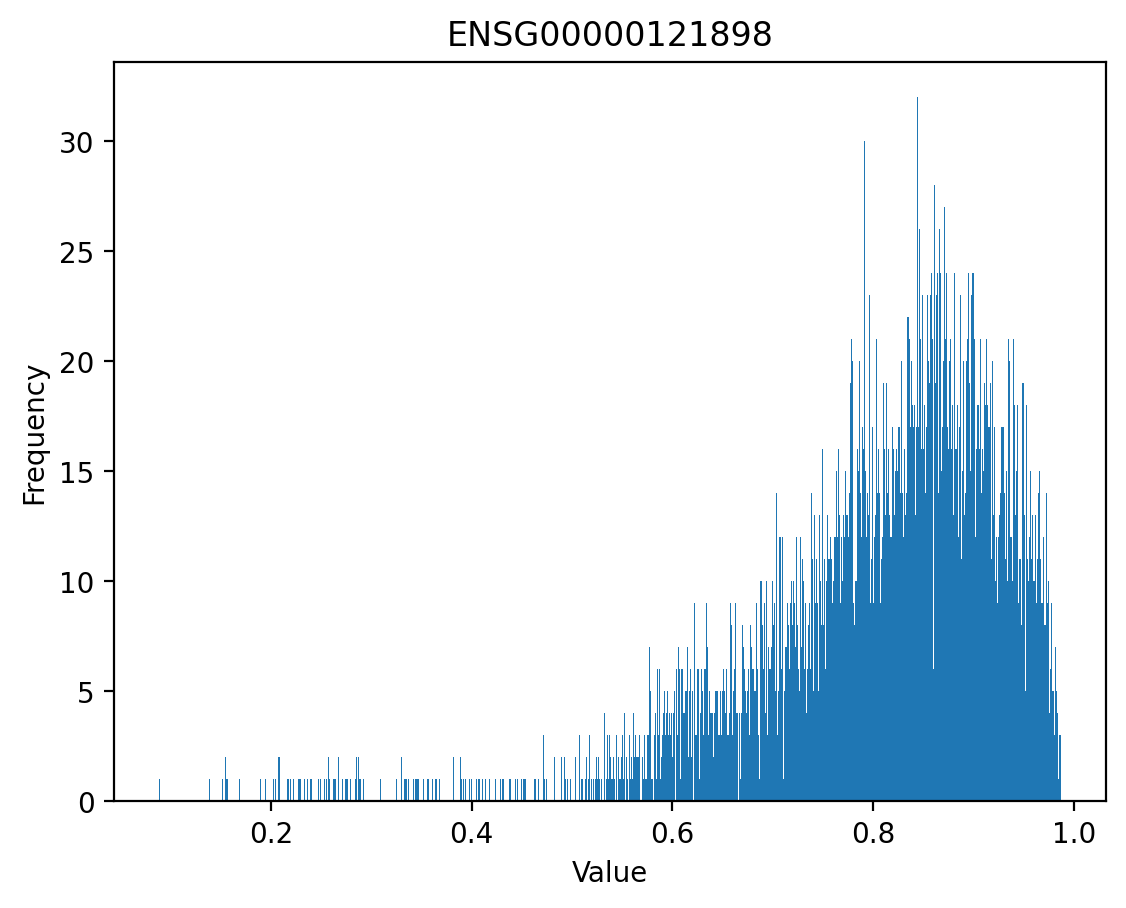

{'mean': 0.8986475454955245, 'median': 0.9287121904359038, 'minimum': 0.44826868323321156, 'maximum': 0.9945962529032818, 'q1': 0.8838251793830844, 'q3': 0.9635682170126223}


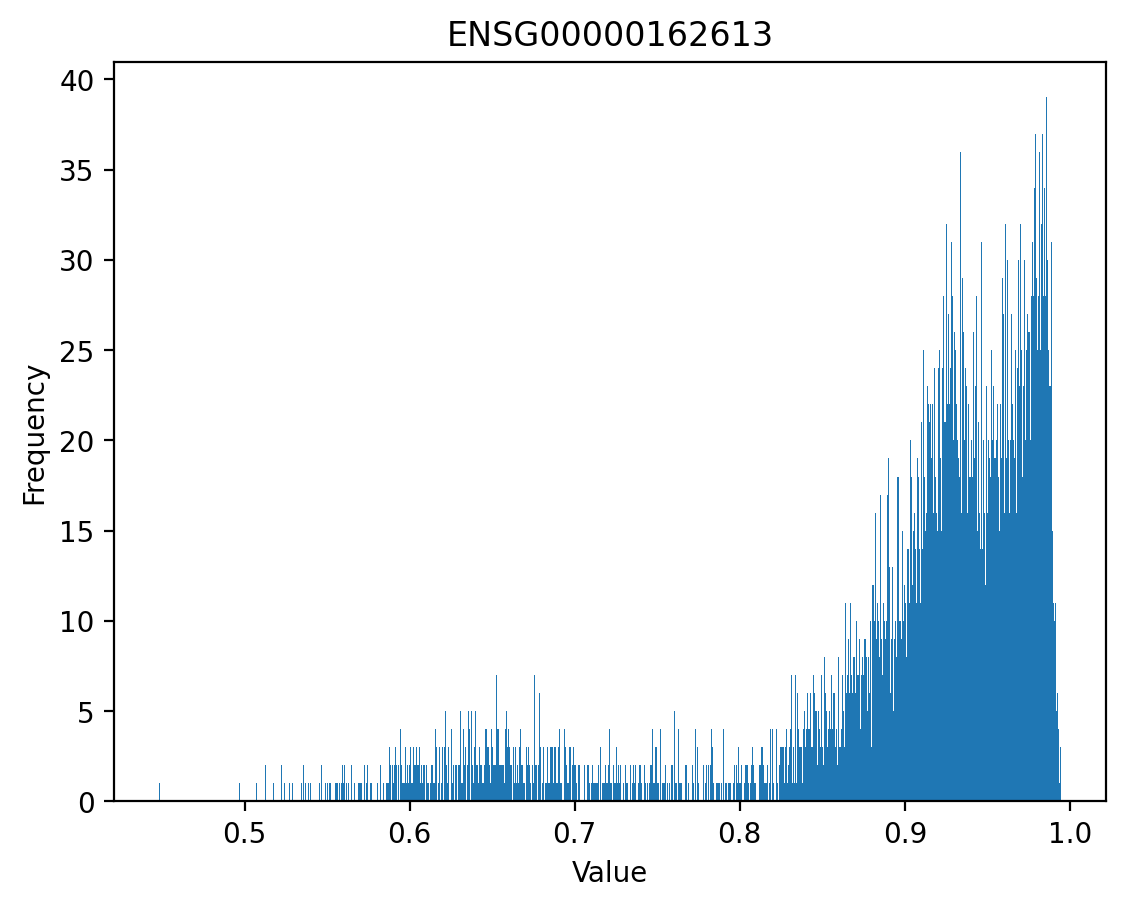

{'mean': 0.8045267661551807, 'median': 0.8533021666864998, 'minimum': 0.04249028764892999, 'maximum': 0.9829007173160716, 'q1': 0.7808240903986677, 'q3': 0.9162318636964755}


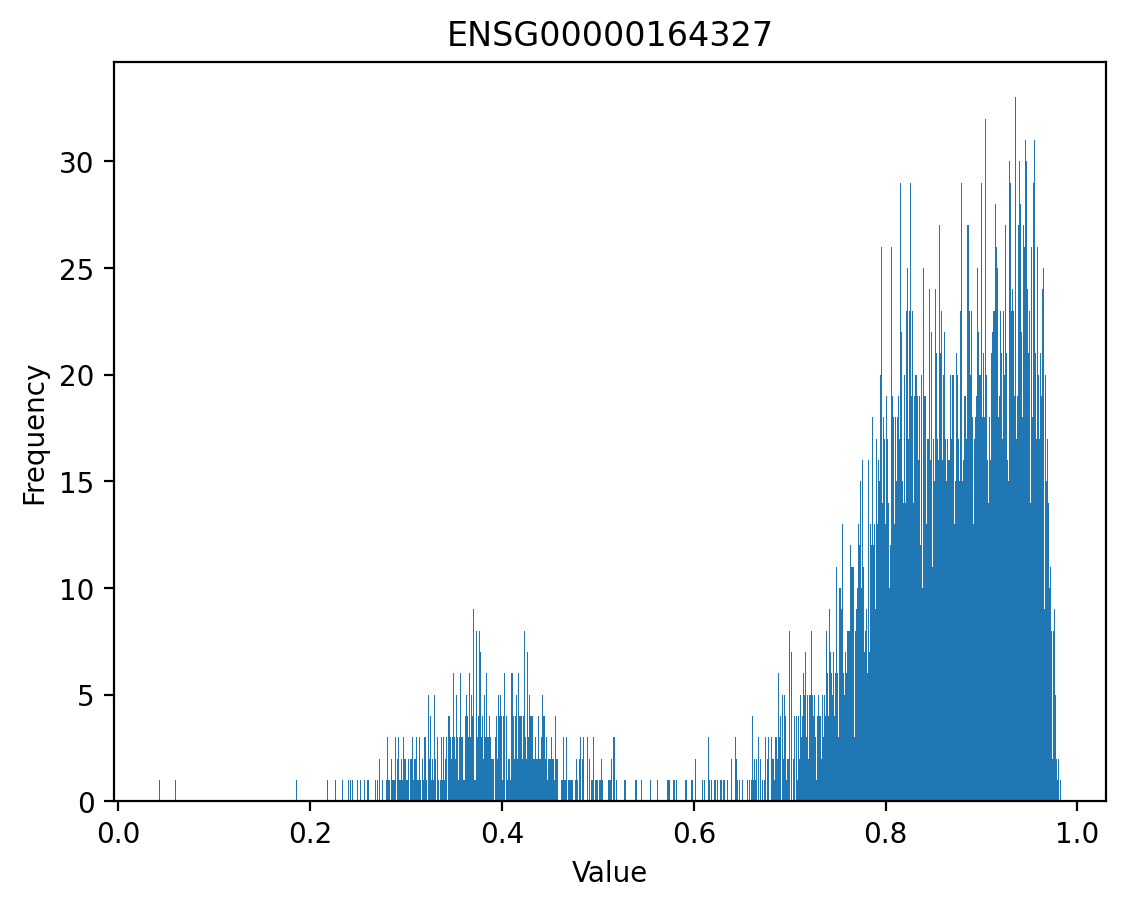

{'mean': 0.9153468696782503, 'median': 0.9217565843086337, 'minimum': 0.24337527243785198, 'maximum': 0.9960668159468162, 'q1': 0.8843923256605982, 'q3': 0.9570777829613587}


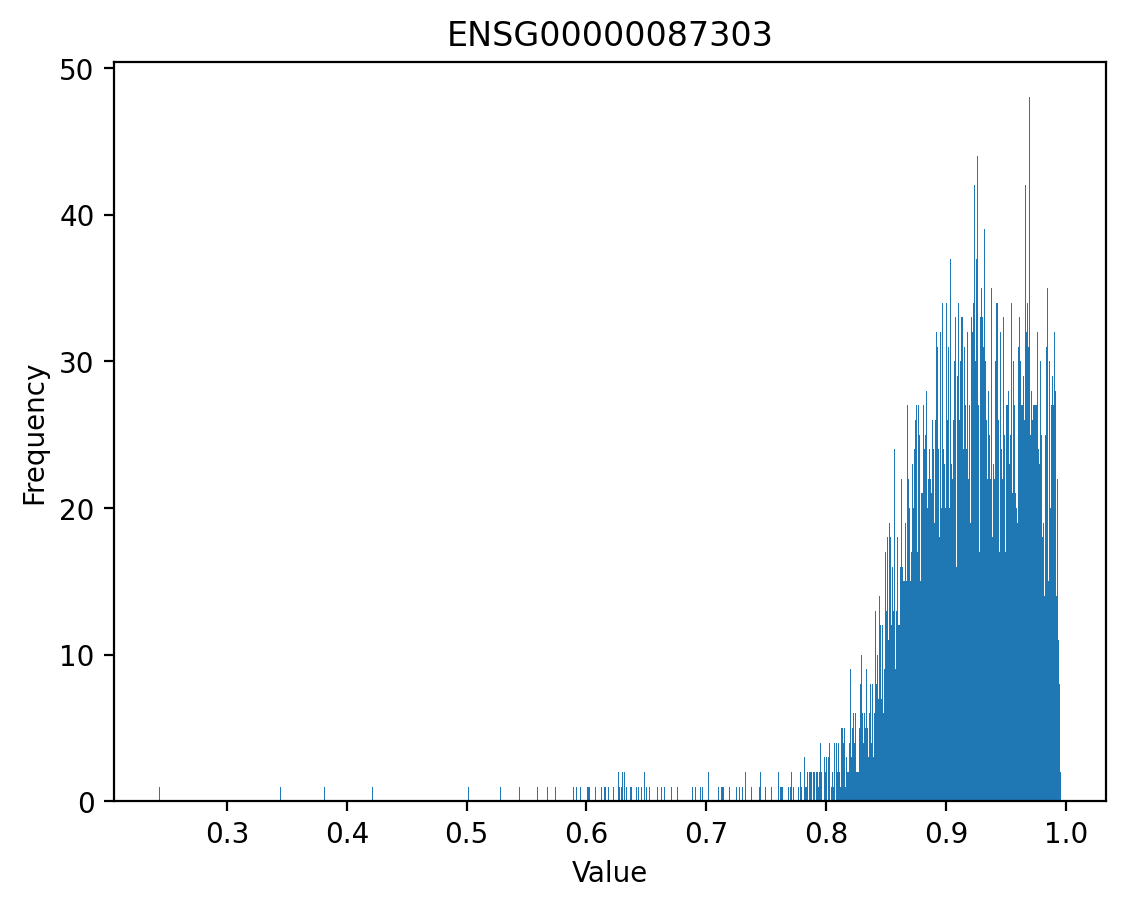

{'mean': 0.9067276703056678, 'median': 0.9487685336551595, 'minimum': 0.3544397363159794, 'maximum': 0.9962932767154381, 'q1': 0.9172946319240809, 'q3': 0.9721852288345812}


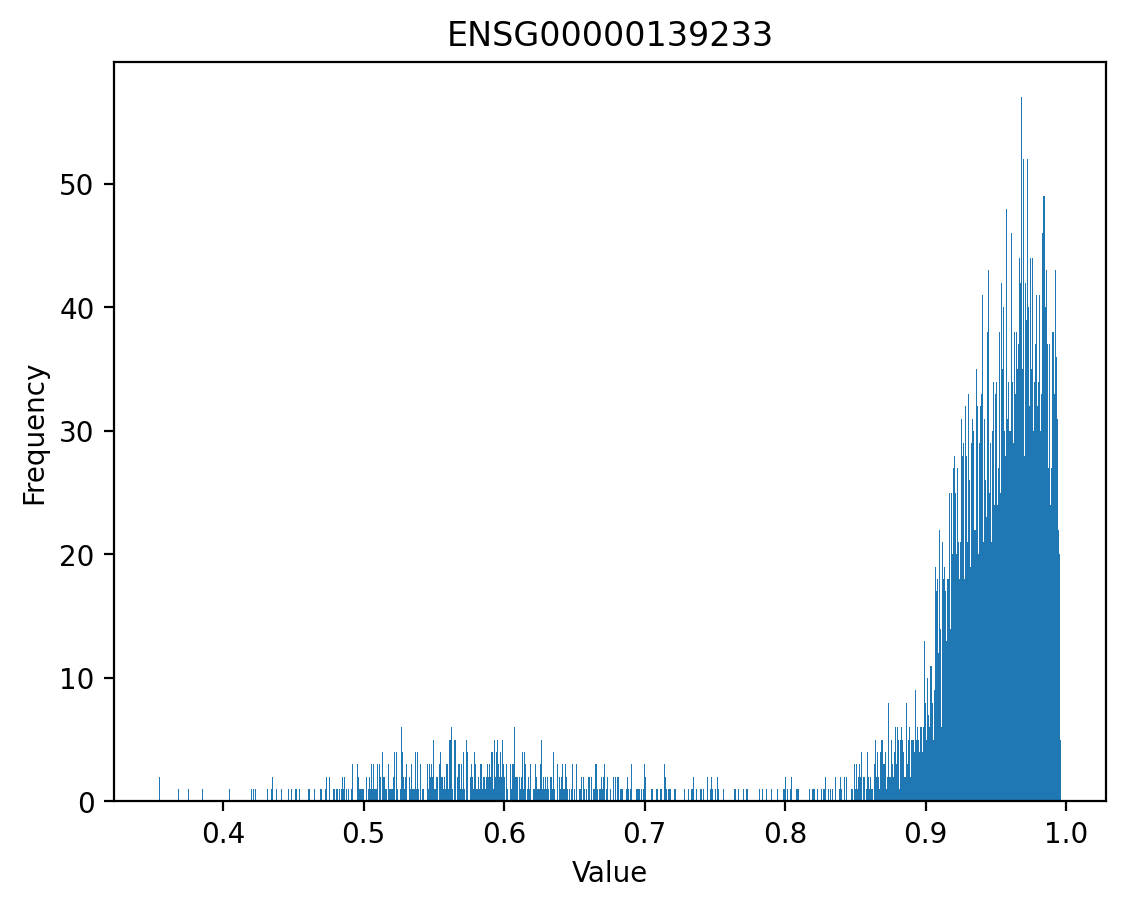

{'mean': 0.9685002179647139, 'median': 0.9718918783698673, 'minimum': 0.5774837936897961, 'maximum': 0.9970822682600515, 'q1': 0.9603764167762545, 'q3': 0.983808164894418}


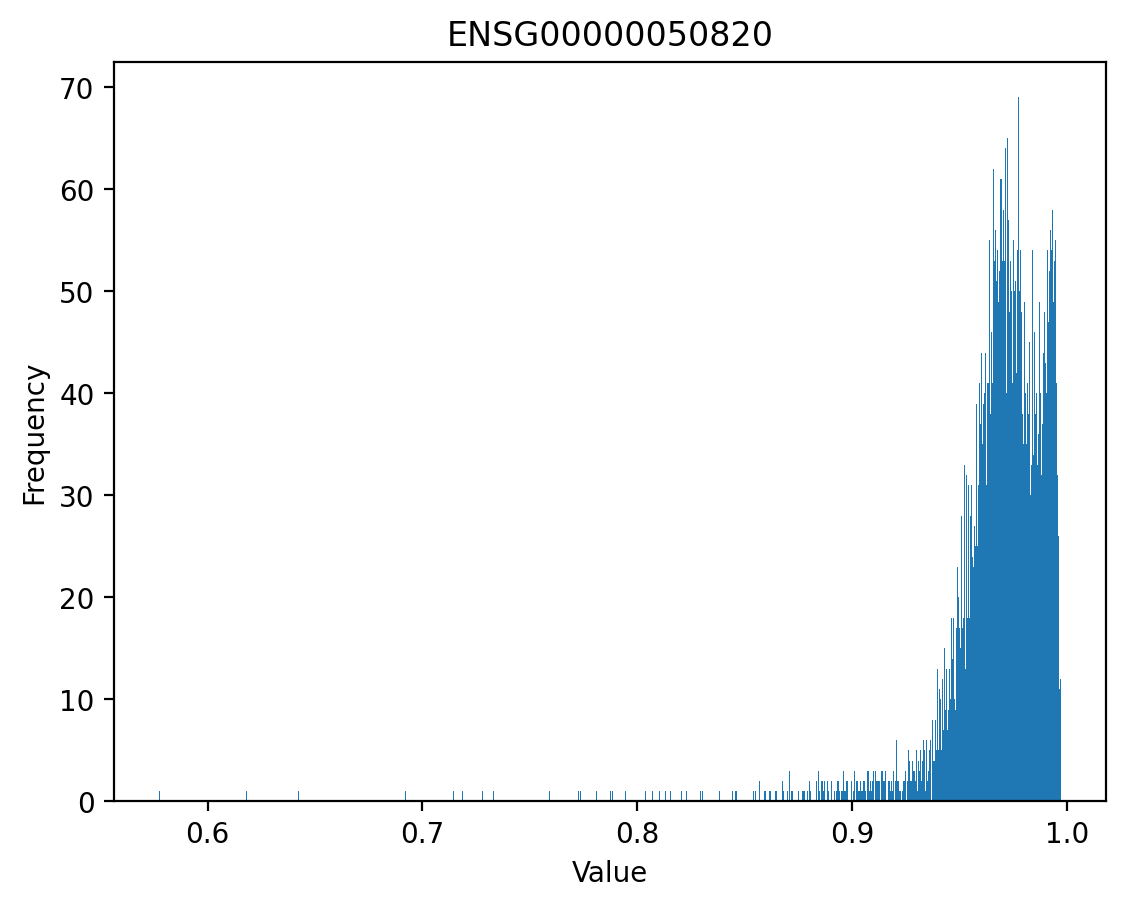

{'mean': 0.8188228830558877, 'median': 0.8774429361059797, 'minimum': 0.15878411819220745, 'maximum': 0.9908752372163073, 'q1': 0.806399316249025, 'q3': 0.9316126393219638}


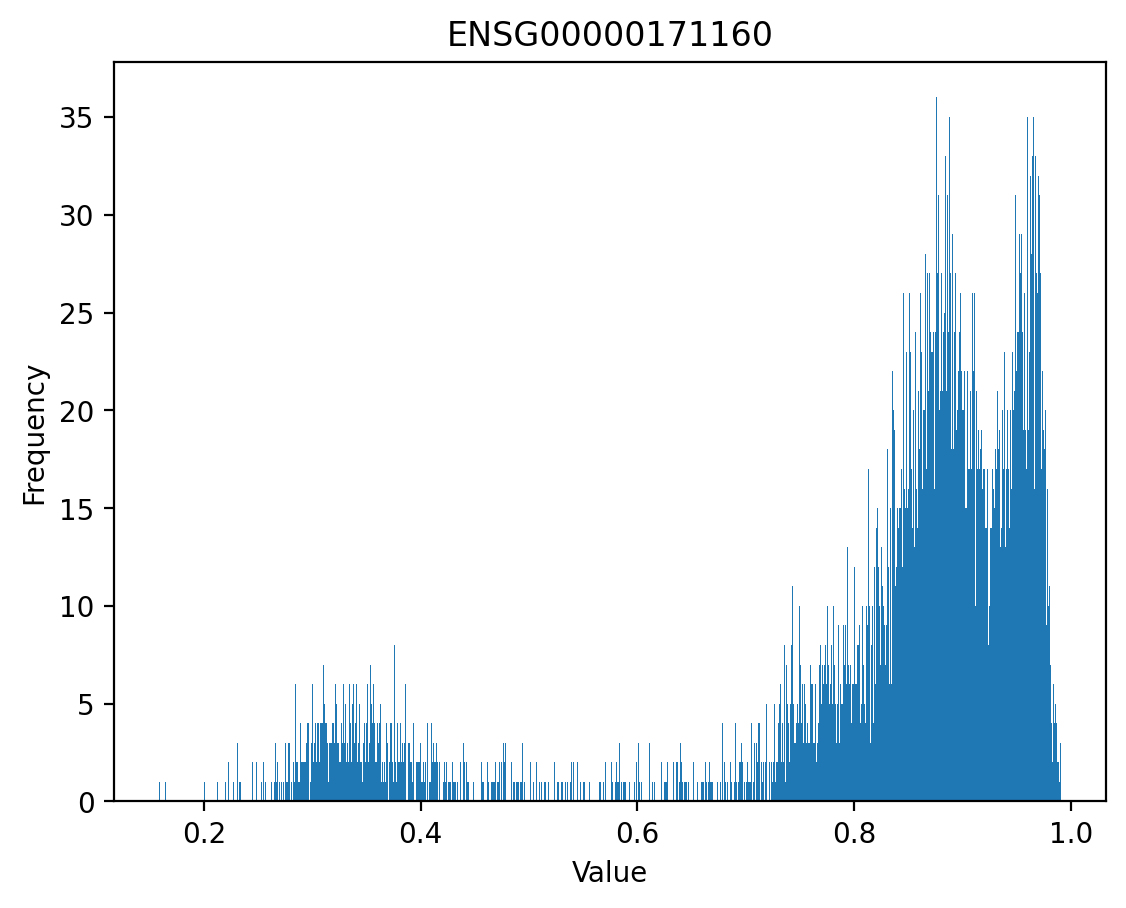

{'mean': 0.8244396183353139, 'median': 0.8766614272845572, 'minimum': 0.21515277099870878, 'maximum': 0.9734314614679092, 'q1': 0.8314860244560973, 'q3': 0.9116283548886374}


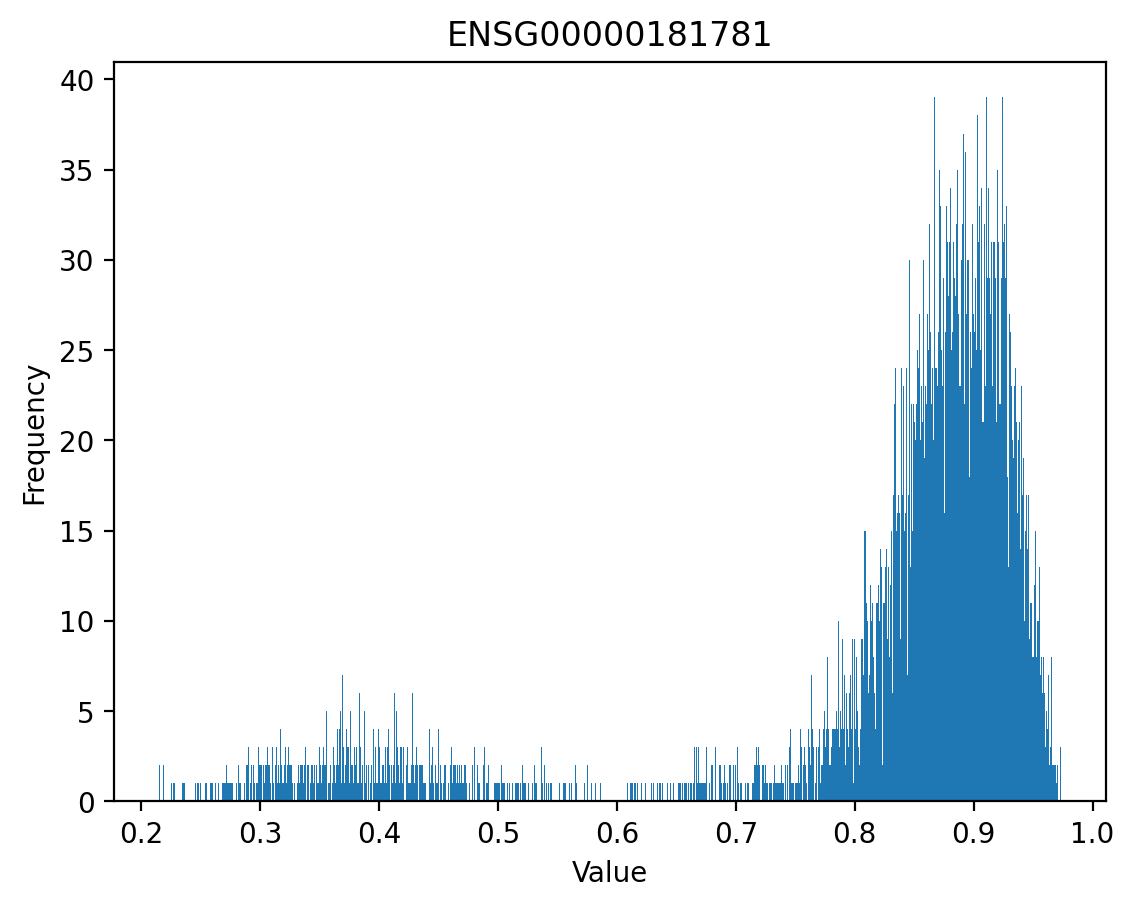

{'mean': 0.9224101439094681, 'median': 0.9397228749133515, 'minimum': 0.6120791237641421, 'maximum': 0.9941067107710185, 'q1': 0.9002750036208108, 'q3': 0.9632379272802634}


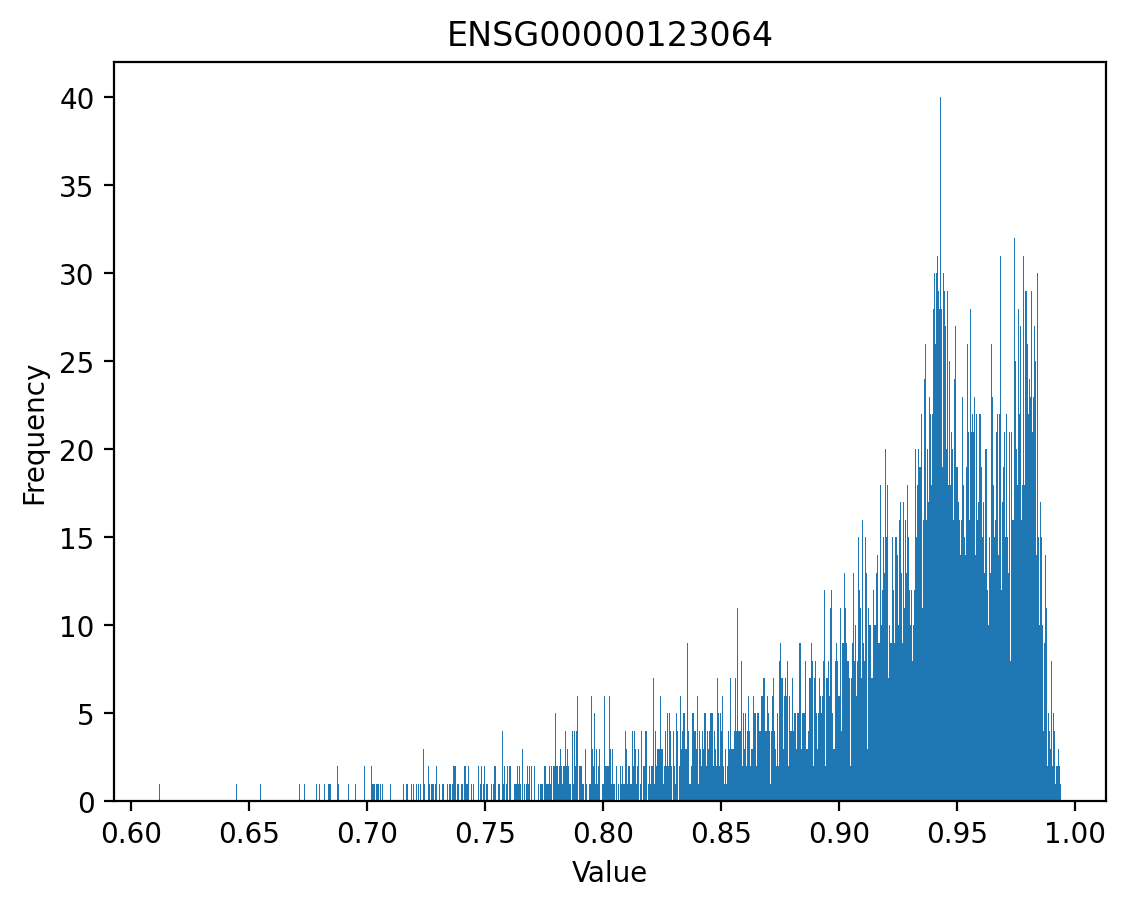

{'mean': 0.9115669859866135, 'median': 0.9701754129932663, 'minimum': 0.2662981770716635, 'maximum': 0.9971998874233308, 'q1': 0.9490859996588221, 'q3': 0.9862075624647917}


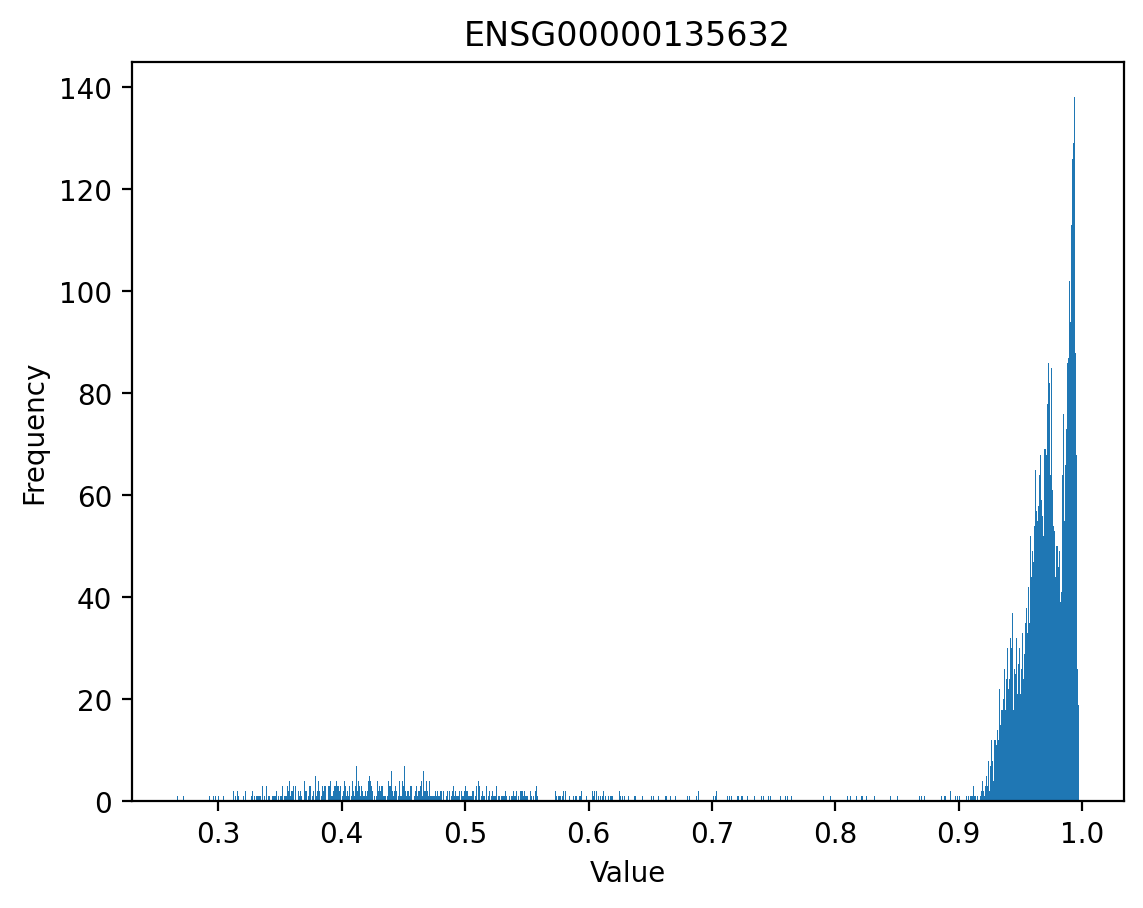

In [18]:
for gene in corr_dict.keys():
    print(get_summary(corr_dict[gene]))
    plot_hist(corr_dict[gene], 1000, title=gene)

This is pretty bad. But we'll still plot the brain CAGE tracks, in case the root of our problems is bin indexing.

In [25]:
#| code-fold: true
annot_df = pd.read_csv("/home/s1mi/enformer_rat_data/annotation/hg38.protein_coding_TSS.txt", sep="\t", index_col='ensembl_gene_id')
def plot_CAGE_tracks(gene):
    gene_annot = annot_df.loc[gene]
    start = gene_annot['transcription_start_site'] - 57344
    end = gene_annot['transcription_start_site'] + 57344
    target_interval = kipoiseq.Interval(f"chr{gene_annot['chromosome_name']}", start, end)
    tracks = {"Centered at TSS": tss_predictions[gene][:, 4980],
              "Queried from reference": predicted_reference_epigenome[gene][:,4980]}
    plot_tracks(tracks, target_interval)

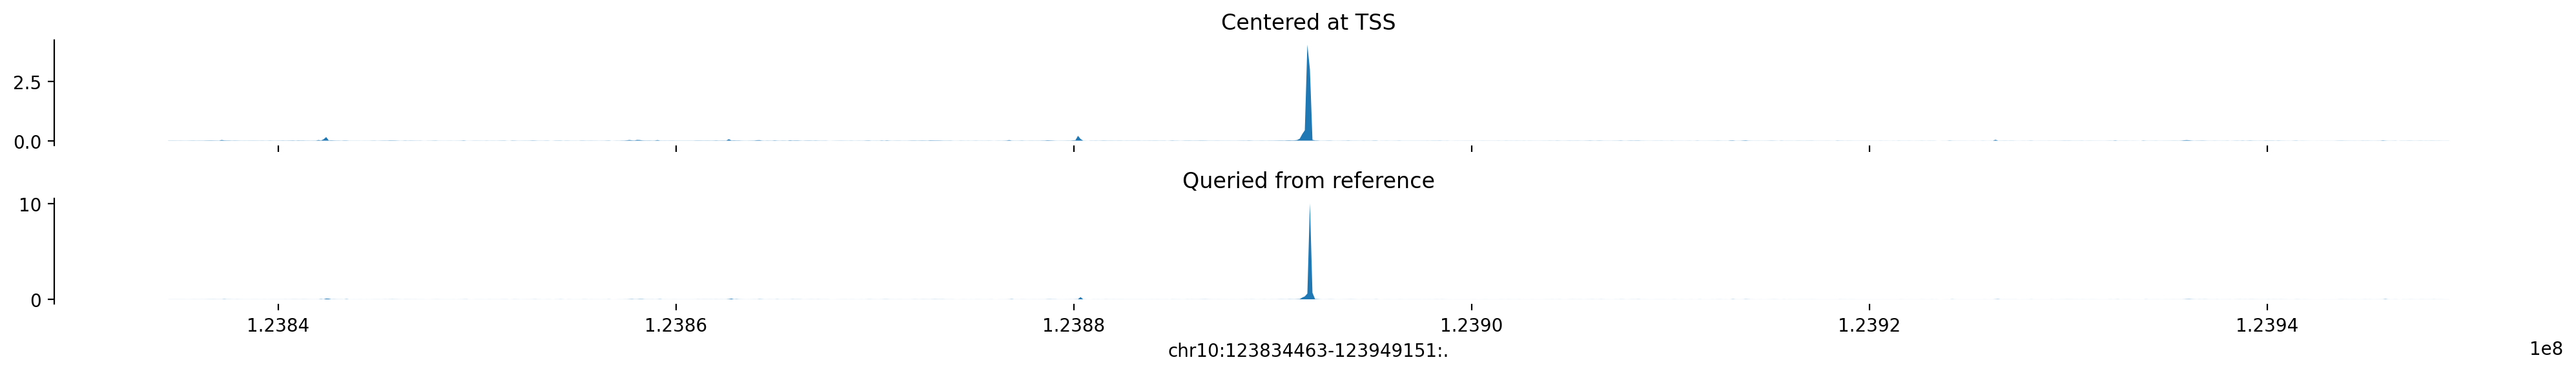

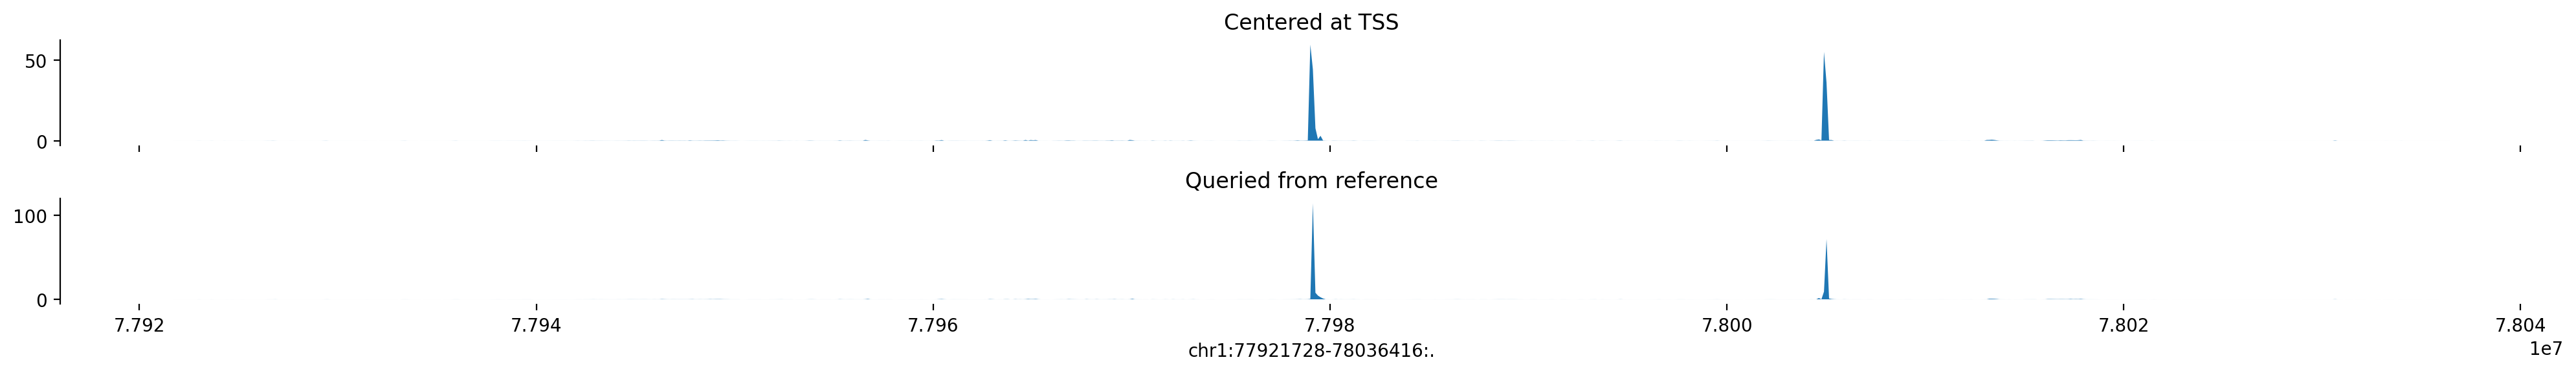

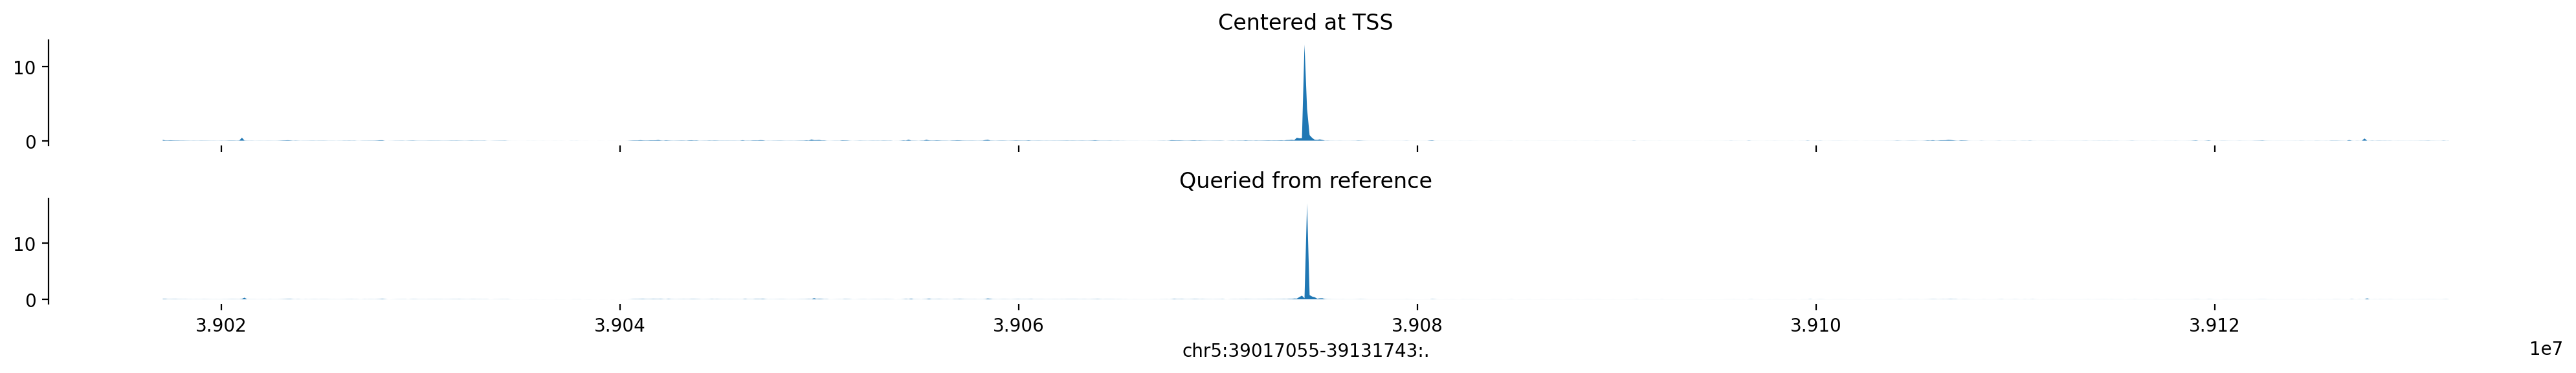

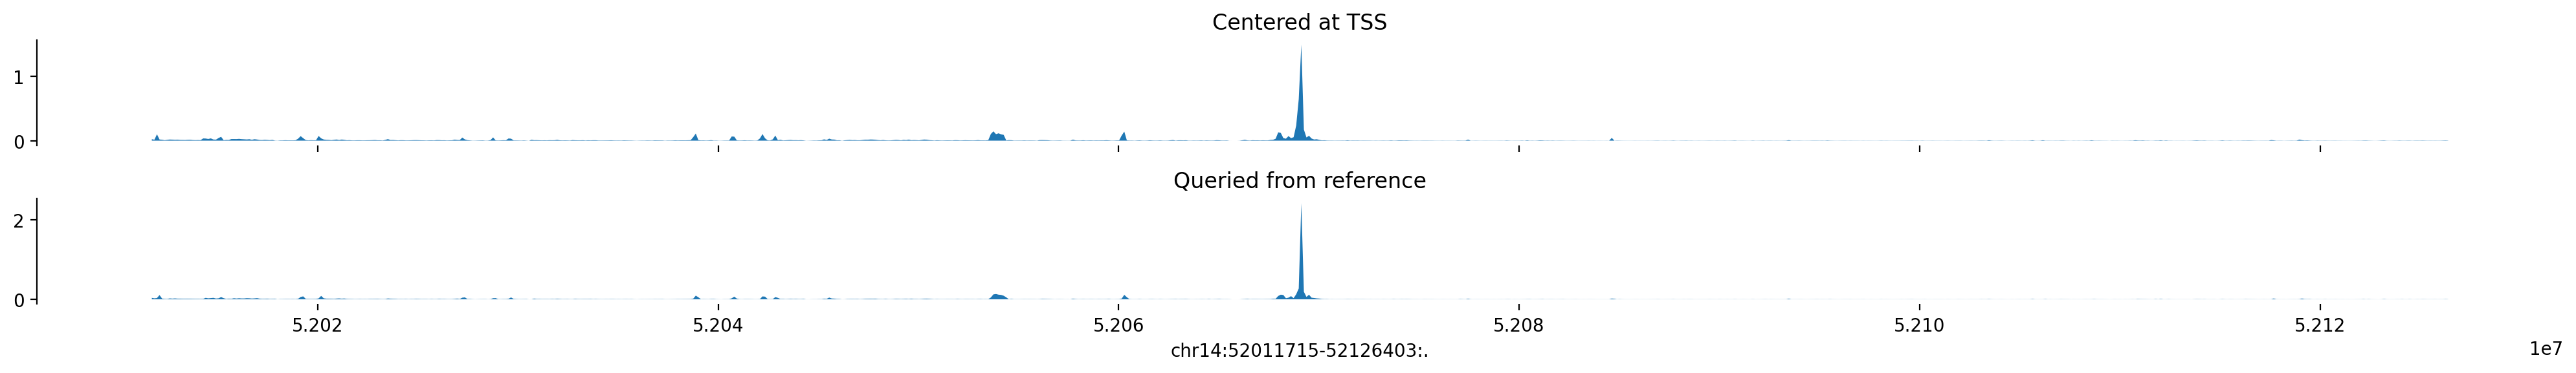

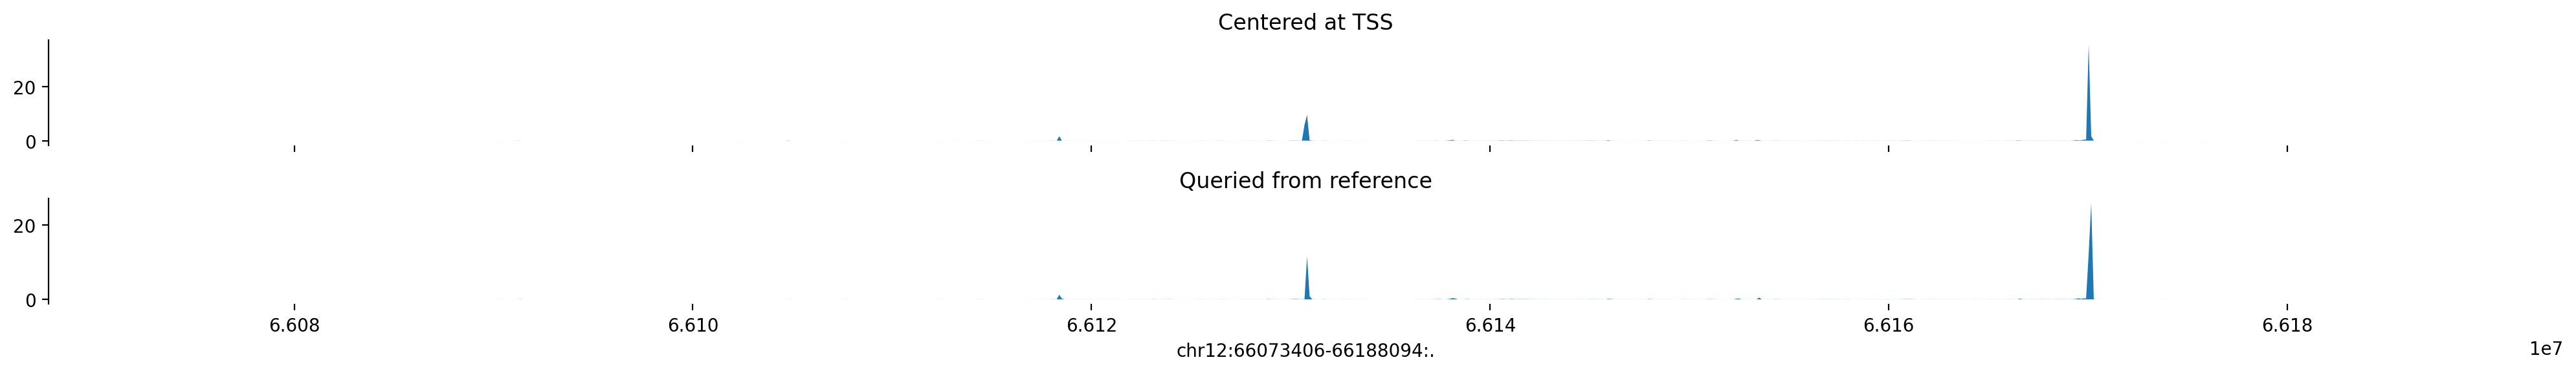

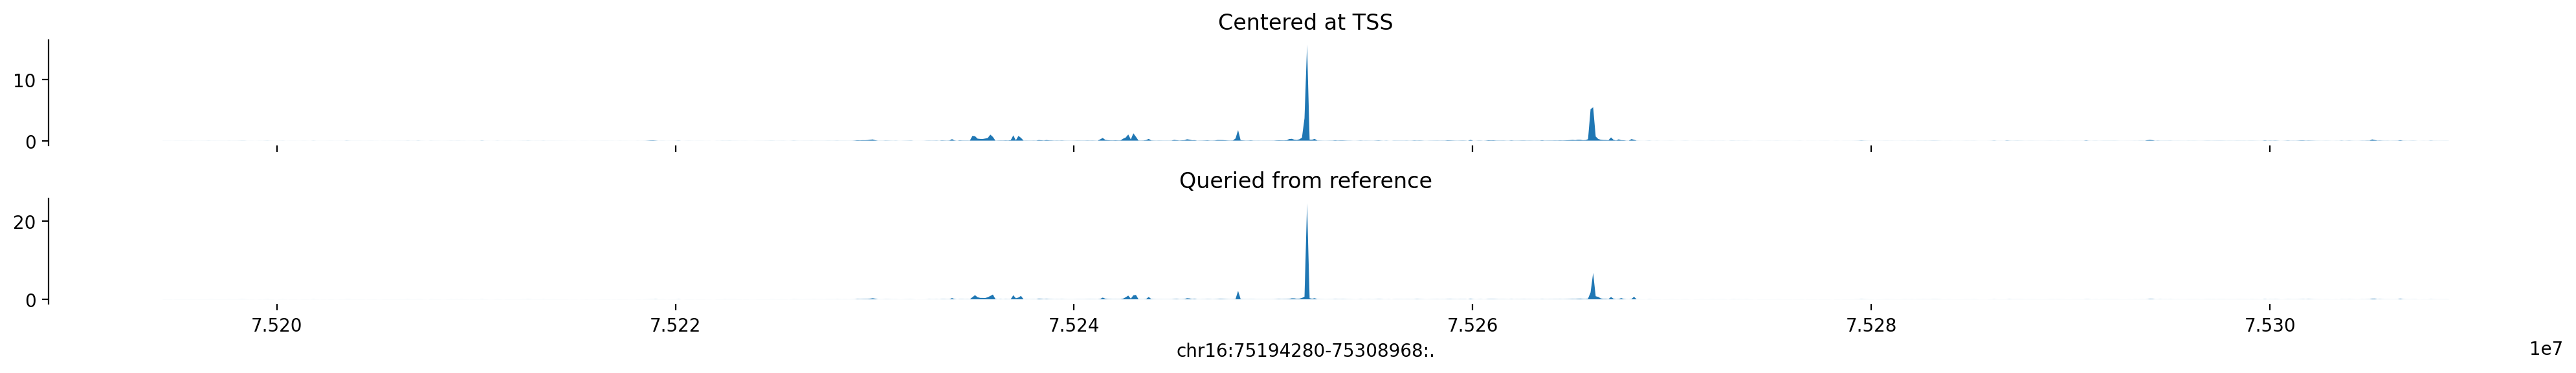

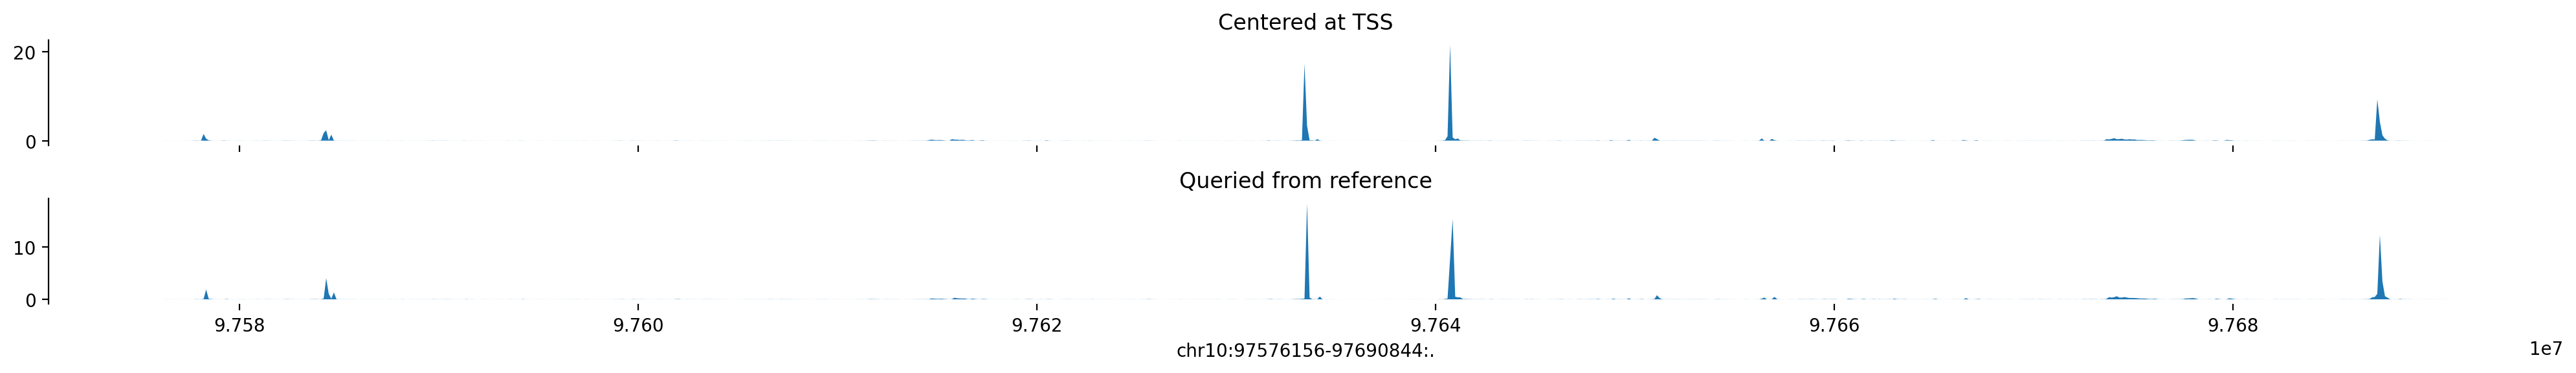

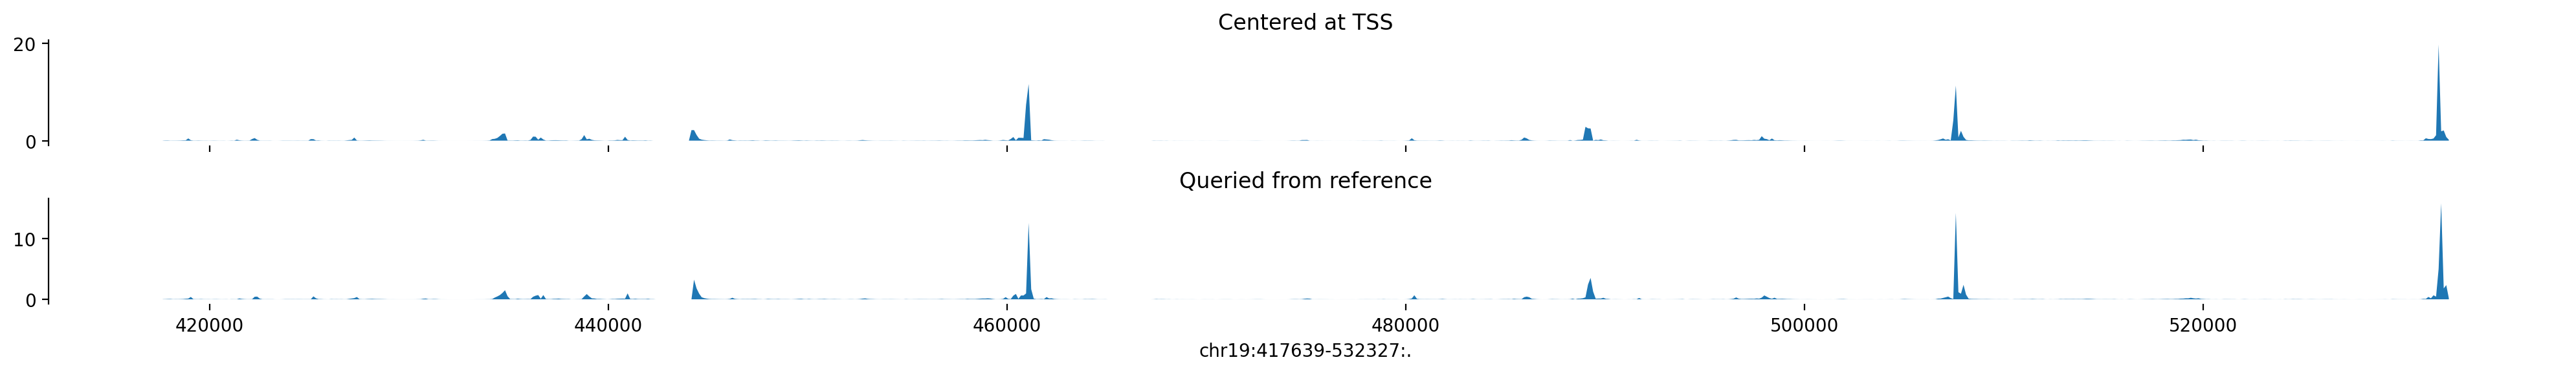

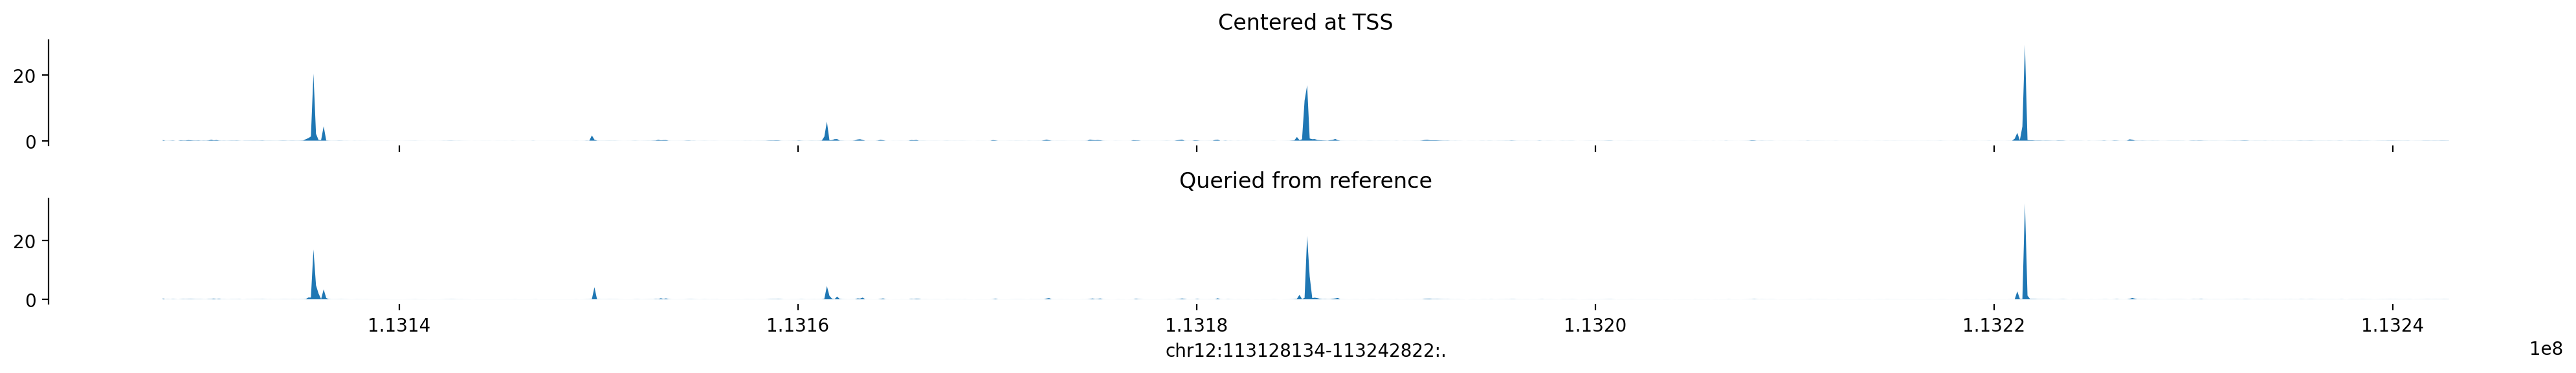

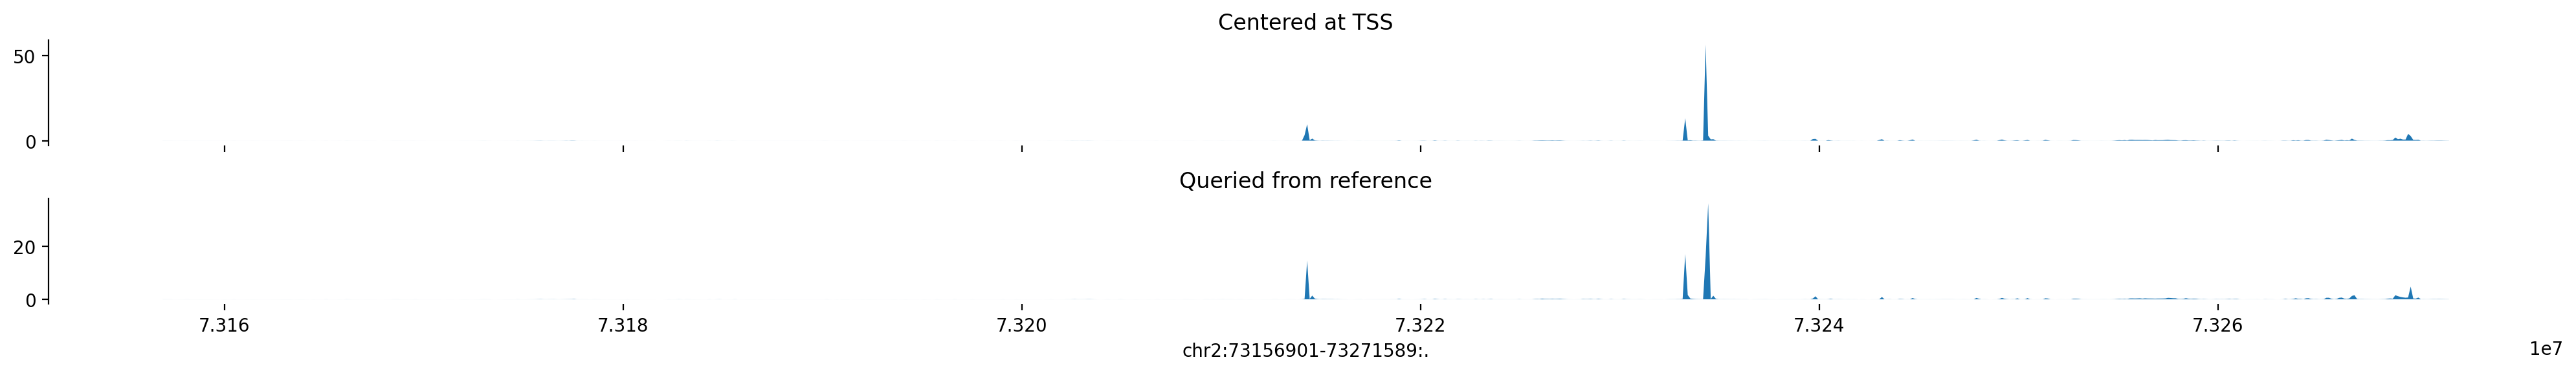

In [26]:
for gene in tss_predictions.keys():
    plot_CAGE_tracks(gene)

At least for the CAGE:Brain track, centering the input sequence at the TSS does not noticeably affect prediction along bins. But it is worth noting that the peaks predicted by centering sequences at TSS look slightly wider than when predicting in a fixed 448 bin window. Let's query 8 bins around the TSS to verify. (In theory, the TSS will land on index 448 in both cases, or index 4 in the 8 bin window.)

In [35]:
for gene in corr_dict.keys():
    print(gene)
    df = pd.DataFrame({
        "Centered at TSS": tss_predictions[gene][444:452, 4980],
        "Queried from reference": predicted_reference_epigenome[gene][444:452, 4980]
    })
    print(df.transpose())

ENSG00000121898
                               0         1         2         3          4  \
Centered at TSS         0.082086  0.279907  0.440625  4.071788   3.021415   
Queried from reference  0.026973  0.184488  0.306243  0.599280  10.036044   

                               5         6         7  
Centered at TSS         0.033681  0.012400  0.010115  
Queried from reference  0.683917  0.033996  0.018840  
ENSG00000162613
                               0         1         2          3           4  \
Centered at TSS         0.076932  0.107431  0.190104  59.414913   44.131977   
Queried from reference  0.054259  0.077803  0.129248   0.457014  113.825249   

                               5         6         7  
Centered at TSS         7.694908  0.878686  3.008540  
Queried from reference  7.781330  4.396933  2.460186  
ENSG00000164327
                               0         1         2          3          4  \
Centered at TSS         0.392323  0.314011  0.328351  12.959496   4.288091

Now the difference is much more noticeable. Let's confirm with a correlation test for CAGE:Brain track.

In [48]:
for gene in corr_dict.keys():
    col_corr = np.corrcoef(tss_predictions[gene][:, 4980], predicted_reference_epigenome[gene][:, 4980])[0, 1]
    dist = annot_df.loc[gene]['transcription_start_site'] % 57344
    print(gene, "\nCorrelation:", col_corr, "\nTSS distance from center:", min(dist, 57344 - dist))

ENSG00000121898 
Correlation: 0.6396015700677352 
TSS distance from center: 28577
ENSG00000162613 
Correlation: 0.6089762800309391 
TSS distance from center: 8768
ENSG00000164327 
Correlation: 0.3250502250053843 
TSS distance from center: 23135
ENSG00000087303 
Correlation: 0.94357261835514 
TSS distance from center: 707
ENSG00000139233 
Correlation: 0.510355799911747 
TSS distance from center: 13118
ENSG00000050820 
Correlation: 0.9543710850658597 
TSS distance from center: 16296
ENSG00000171160 
Correlation: 0.36819984155156643 
TSS distance from center: 23332
ENSG00000181781 
Correlation: 0.6519049075736117 
TSS distance from center: 16231
ENSG00000123064 
Correlation: 0.9232435790584608 
TSS distance from center: 11578
ENSG00000135632 
Correlation: 0.5146963218167778 
TSS distance from center: 14043


The distance between the gene TSS and the center of input sequence is likely affecting predictions. Now we'll want to consider whether centering at the TSS improves predictions based on a *very* small sample of 10 genes.

## Compare to GTEx gene expression

In [63]:
gtex_tpm = pd.read_csv("/home/s1mi/enformer_rat_data/expression_data/gene_tpm_2017-06-05_v8_brain_cortex.gct.gz", header=2, sep="\t")
gtex_tpm['Name'] = gtex_tpm['Name'].apply(lambda gene: gene.split('.')[0])
gtex_tpm.set_index('Name', inplace=True)
# Calculate average gene expression
gtex_mean_tpm = gtex_tpm.drop(columns=['id', 'Description']).mean(axis=1)
gtex_mean_tpm.name = 'GTEx'

In [69]:
## Quantify predicted gene expression
df = pd.DataFrame({
    "Centered at TSS": [np.average(tss_predictions[gene][446:450, 4980]) for gene in tss_predictions.keys()],
    "Queried from reference": [np.average(predicted_reference_epigenome[gene][446:450, 4980]) for gene in predicted_reference_epigenome.keys()]
    }, index = tss_predictions.keys())

In [70]:
reference_gex_df = df.merge(gtex_mean_tpm, left_index=True, right_index=True, how='inner')
print(reference_gex_df)

                 Centered at TSS  Queried from reference       GTEx
ENSG00000050820         9.676256               12.648662  20.471502
ENSG00000087303         1.070892                1.346782   0.780738
ENSG00000121898         3.546602                5.317662   1.135701
ENSG00000123064        14.531332               10.994039  11.954925
ENSG00000135632         6.431349                7.394567  25.394757
ENSG00000139233         7.678755                5.804458   2.995251
ENSG00000162613        51.773445               57.141132  17.891106
ENSG00000164327         8.623794                8.652374   5.890239
ENSG00000171160        10.297829                9.193137  34.015620
ENSG00000181781         0.126855                0.111838   0.479827


In [71]:
gex_corr = reference_gex_df.corr()
gex_corr

,Centered at TSS,Queried from reference,GTEx
Centered at TSS,1.000000,0.991899,0.324152
Queried from reference,0.991899,1.000000,0.316441
GTEx,0.324152,0.316441,1.000000


It's worth noting that once the four bins around the TSS are averaged, predictions centered at TSS compared to 57,344 bp increments in the reference epigenome are very similar.